In [2]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split
from ast import literal_eval

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [4]:
# Get data
arxiv_data = pd.read_csv(
    "https://github.com/soumik12345/multi-label-text-classification/releases/download/v0.2/arxiv_data.csv"
)
arxiv_data.head()

,titles,summaries,terms
0,Survey on Semantic Stereo Matching / Semantic ...,Stereo matching is one of the widely used tech...,"['cs.CV', 'cs.LG']"
1,FUTURE-AI: Guiding Principles and Consensus Re...,The recent advancements in artificial intellig...,"['cs.CV', 'cs.AI', 'cs.LG']"
2,Enforcing Mutual Consistency of Hard Regions f...,"In this paper, we proposed a novel mutual cons...","['cs.CV', 'cs.AI']"
3,Parameter Decoupling Strategy for Semi-supervi...,Consistency training has proven to be an advan...,['cs.CV']
4,Background-Foreground Segmentation for Interio...,"To ensure safety in automated driving, the cor...","['cs.CV', 'cs.LG']"


In [6]:
# Data information 
print(f"There are {len(arxiv_data)} rows in the dataset.")
total_duplicate_titles = sum(arxiv_data["titles"].duplicated())
print(f"There are {total_duplicate_titles} duplicate titles.")

There are 51774 rows in the dataset.
There are 12802 duplicate titles.


In [8]:
# Data preprocessing
arxiv_data = arxiv_data[~arxiv_data["titles"].duplicated()]
print(f"There are {len(arxiv_data)} rows in the deduplicated dataset.")

# There are some terms with occurrence as low as 1.
print(sum(arxiv_data["terms"].value_counts() == 1))

# How many unique terms?
print(arxiv_data["terms"].nunique())

# Drop lowest occurenence 
arxiv_data_filtered = arxiv_data.groupby("terms").filter(lambda x: len(x) > 1)
arxiv_data_filtered.shape

There are 38972 rows in the deduplicated dataset.
2321
3157


(36651, 3)

In [12]:
# More preprocessing, convert raw strings to list of strings for terms 
arxiv_data_filtered["terms"] = arxiv_data_filtered["terms"].apply(
    lambda x: literal_eval(x)
)
arxiv_data_filtered["terms"].values[:5]

array([list(['cs.CV', 'cs.LG']), list(['cs.CV', 'cs.AI', 'cs.LG']),
       list(['cs.CV', 'cs.AI']), list(['cs.CV']),
       list(['cs.CV', 'cs.LG'])], dtype=object)

In [13]:
# Split data (Stratification to deal with class imbalance)
test_split = 0.1

# Initial train and test split.
train_df, test_df = train_test_split(
    arxiv_data_filtered,
    test_size=test_split,
    stratify=arxiv_data_filtered["terms"].values,
)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 32985
Number of rows in validation set: 1833
Number of rows in test set: 1833


In [14]:
# Vectorization of the multi label binarization 
terms = tf.ragged.constant(train_df["terms"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)

2022-07-07 12:12:44.405246: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-07 12:12:44.480962: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Vocabulary:

['[UNK]', 'cs.CV', 'cs.LG', 'stat.ML', 'cs.AI', 'eess.IV', 'cs.RO', 'cs.CL', 'cs.NE', 'cs.CR', 'math.OC', 'eess.SP', 'cs.GR', 'cs.SI', 'cs.MM', 'cs.SY', 'cs.IR', 'cs.MA', 'eess.SY', 'cs.HC', 'math.IT', 'cs.IT', 'cs.DC', 'stat.AP', 'cs.CY', 'stat.TH', 'math.ST', 'stat.ME', 'eess.AS', 'cs.SD', 'q-bio.QM', 'q-bio.NC', 'cs.DS', 'cs.GT', 'cs.CG', 'cs.SE', 'cs.NI', 'I.2.6', 'stat.CO', 'math.NA', 'cs.NA', 'physics.chem-ph', 'cs.DB', 'q-bio.BM', 'cs.PL', 'cs.LO', 'cond-mat.dis-nn', '68T45', 'math.PR', 'physics.comp-ph', 'cs.CE', 'cs.AR', 'I.2.10', 'q-fin.ST', 'cond-mat.stat-mech', 'quant-ph', 'math.DS', '68T05', 'physics.data-an', 'cs.CC', 'I.4.6', 'physics.soc-ph', 'physics.ao-ph', 'econ.EM', 'cs.DM', 'q-bio.GN', 'physics.med-ph', 'astro-ph.IM', 'I.4.8', 'math.AT', 'cs.PF', 'I.4', 'q-fin.TR', 'cs.FL', 'I.5.4', 'I.2', '68U10', 'physics.optics', 'hep-ex', '68T10', 'physics.geo-ph', 'cond-mat.mtrl-sci', 'q-fin.CP', 'physics.flu-dyn', 'math.CO', 'math.AP', 'I.4; I.5', 'I.4.9', 'I.2.6

In [16]:
# Binarization 
sample_label = train_df["terms"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

['cs.LG', 'stat.ML']
Original label: ['cs.LG', 'stat.ML']
Label-binarized representation: [[0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [18]:
# More preprocessing
train_df["summaries"].apply(lambda x: len(x.split(" "))).describe()

max_seqlen = 160
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["terms"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["summaries"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

In [19]:
# preview dataset
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Abstract: b'Research in machine learning, mobile robotics, and autonomous driving is\naccelerated by the availability of high quality annotated data. To this end, we\nrelease the Audi Autonomous Driving Dataset (A2D2). Our dataset consists of\nsimultaneously recorded images and 3D point clouds, together with 3D bounding\nboxes, semantic segmentation, instance segmentation, and data extracted from\nthe automotive bus. Our sensor suite consists of six cameras and five LiDAR\nunits, providing full 360 degree coverage. The recorded data is time\nsynchronized and mutually registered. Annotations are for non-sequential\nframes: 41,277 frames with semantic segmentation image and point cloud labels,\nof which 12,497 frames also have 3D bounding box annotations for objects within\nthe field of view of the front camera. In addition, we provide 392,556\nsequential frames of unannotated sensor data for recordings in three cities in\nthe south of Germany. These sequences contain several loops. Face

In [22]:
# Vectorization
# Source: https://stackoverflow.com/a/18937309/7636462
vocabulary = set()
train_df["summaries"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

153341


In [23]:
# Model 
def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return shallow_mlp_model

258/258 [==============================] - 56s 213ms/step - loss: 0.0321 - categorical_accuracy: 0.8534 - val_loss: 0.0182 - val_categorical_accuracy: 0.8969


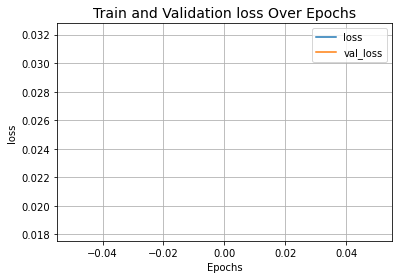

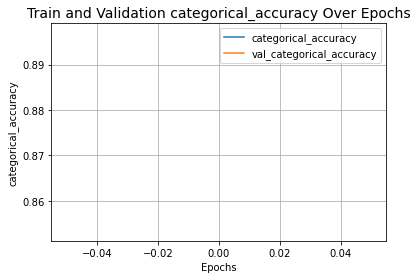

In [29]:
# Train 
epochs = 1

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["categorical_accuracy"]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")

In [30]:
# Evaluation 
_, categorical_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(categorical_acc * 100, 2)}%.")

15/15 [==============================] - 1s 70ms/step - loss: 0.0186 - categorical_accuracy: 0.8898
Categorical accuracy on the test set: 88.98%.


In [31]:
# End to End model 
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_3_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:3]
    print(f"Predicted Label(s): ({', '.join([label for label in top_3_labels])})")
    print(" ")

Abstract: b'Machine learning classifiers are often trained to recognize a set of\npre-defined classes. However, in many applications, it is often desirable to\nhave the flexibility of learning additional concepts, with limited data and\nwithout re-training on the full training set. This paper addresses this\nproblem, incremental few-shot learning, where a regular classification network\nhas already been trained to recognize a set of base classes, and several extra\nnovel classes are being considered, each with only a few labeled examples.\nAfter learning the novel classes, the model is then evaluated on the overall\nclassification performance on both base and novel classes. To this end, we\npropose a meta-learning model, the Attention Attractor Network, which\nregularizes the learning of novel classes. In each episode, we train a set of\nnew weights to recognize novel classes until they converge, and we show that\nthe technique of recurrent back-propagation can back-propagate through t